In [1]:
import time

import pyart
import numpy as np
import os, sys
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm

# add location of local leroy modules to sys.path and import them
import leroi


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



# Quality Control

In [2]:
field = 'corrected_reflectivity'
dbz_field = 'corrected_reflectivity'
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    radar = pyart.io.read("/g/data/hj10/cpol/cpol_level_1b/v2020/ppi/2002/20021102/twp10cpolppi.b1.20021102.150000.nc")
    radar.add_field_like(field, field+'_original', radar.fields[field]['data'])
    radar = leroi.mask_invalid_data(radar, dbz_field, add_to = [field], min_field = 5, min_area = 50, return_smooth = False)

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


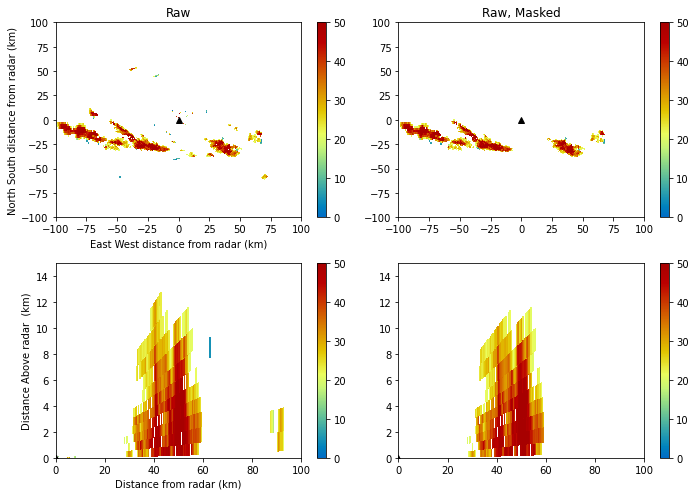

In [3]:
# plot in radar coordinates

gb = ((0,15), (-100,100), (-100,100))
rlim = (0,100)
tilt, ray, vmin, vmax = 0,130, 0, 50

display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(221)
ax.plot(0,0, 'k^')
display.plot_ppi(field+'_original', tilt, ax=ax,colorbar_flag= True,
             colorbar_label='',vmin = vmin, vmax = vmax, title=  'Raw',cmap = 'pyart_HomeyerRainbow')
display.set_limits(gb[2], gb[1], ax=ax)

ax = fig.add_subplot(222)
ax.plot(0,0, 'k^')

display.plot_ppi(field+'', tilt, ax=ax,colorbar_flag= True, axislabels_flag = False,
             colorbar_label='',vmin = vmin, vmax = vmax, title=  'Raw, Masked',cmap = 'pyart_HomeyerRainbow')
display.set_limits(gb[2], gb[1], ax=ax)

xsect = pyart.util.cross_section_ppi(radar, [ray])
display = pyart.graph.RadarDisplay(xsect)

ax = fig.add_subplot(223)
ax.plot(0,0, 'k^')

display.plot(field+'_original', 0, colorbar_flag= True, vmin = vmin, vmax = vmax,colorbar_label='',
             title=  '',cmap = 'pyart_HomeyerRainbow')
display.set_limits(rlim, gb[0], ax=ax)
display = pyart.graph.RadarDisplay(xsect)

ax = fig.add_subplot(224)
ax.plot(0,0, 'k^')

display.plot(field+'', 0, colorbar_flag= True, vmin = vmin, vmax = vmax, title=  '',colorbar_label='',
             axislabels_flag = False,cmap = 'pyart_HomeyerRainbow')
display.set_limits(rlim, gb[0], ax=ax)

plt.tight_layout()
plt.show()

In [25]:
import warnings
import multiprocessing as mp

import pyart
import numpy as np
from scipy.spatial import cKDTree
from scipy.signal import savgol_filter
from scipy.interpolate import RegularGridInterpolator
from astropy.convolution import convolve


def get_leroy_roi(radar, coords, frac=0.55):
    """
    Get a radius of influence for the ppis based on the azimuthal spacing of each sweep
    
    Refer to Dahl et al (2019) for details here. 
    """
    roi = 0
    rmax = np.sqrt(max(coords[0]) ** 2 + max(coords[1]) ** 2 + max(coords[2]) ** 2)
    for i in range(radar.nsweeps):
        az = np.amax(np.radians(np.amax(np.diff(np.sort(radar.azimuth["data"][radar.get_slice(i)])))))
        r = frac * az * rmax
        if r > roi:
            roi = r
    return roi


def cressman_ppi_interp(
    radar, coords, field_names, Rc=None, k=100, filter_its=0, verbose=True, kernel=None, corr_lens=None
):
    """
    Interpolate multiple fields from a radar object to a grid. This 
    is an implementation of the method described in Dahl et. al. (2019).
    
    Inputs:
    radar (Pyart object): radar to be interpolated
    coords (tuple): tuple of 3 1d arrays containing z, y, x of grid
    field_names (list or string): field names in radar to interpolate
    Rc (float): Cressman radius of interpolation, calculated if not supplied
    k (int): max number of points within a radius of influence
    filter_its (int): number of filter iterations for the low-pass filter
    kernel (astropy.kernel): user defined kernel for smoothing (boxcar filter if not specified)
    corr_lens (tuple): correlation lengths for smoothing filter in vert. and horiz. dims resp.
    
    """
    import time
    start = time.time()
    
    if type(field_names) != list:
        field_names = [
            field_names,
        ]

    fields = []
    dims = [len(coord) for coord in coords]
    #Z, Y, X = np.meshgrid(coords[0], coords[1], coords[2], indexing="ij")
    if filter_its > 0:
        dz = np.mean(np.diff(np.sort(coords[0])))
        dy = np.mean(np.diff(np.sort(coords[1])))
        dx = np.mean(np.diff(np.sort(coords[2])))
        dh = np.mean((dy, dx))

    if Rc is None:
        Rc = get_leroy_roi(radar, coords, frac=0.55)
        if verbose:
            print("Radius of influence set to {} m.".format(Rc))
            
    ppi_height, w_slices, idx_slices = generate_ppi_interpolant(radar, coords, Rc, k=k)
    end = time.time()
    print('init', end-start)
    
    if ppi_height.mask.sum() > 0:
        warnings.warn(
            """\n There are invalid height values which will 
        ruin the linear interpolation. This most likely means the radar
        doesnt cover the entire gridded domain"""
        )
        
    start = time.time()
    if verbose:
        print("Interpolating...")
    for field in field_names:
        ppis = apply_ppi_interpolant(radar, coords, field, w_slices, idx_slices)
        grid = interp_along_axis(ppis.filled(np.nan), ppi_height, Z, axis=0, method="linear")

        if filter_its > 0:
            if verbose:
                print("Filtering...")

            if kernel is None:
                if corr_lens == None:
                    raise NotImplementedError(
                        """You must either input a convolution kernel 
                        ('kernel') or some correlation lengths ('corr_len')."""
                    )
                v_window = int(np.ceil(corr_lens[0] / dz) // 2 * 2 + 1)
                h_window = int(np.ceil(corr_lens[1] / dh) // 2 * 2 + 1)
                kernel = np.ones((v_window, h_window, h_window)) / np.float(v_window * h_window * h_window)

            smooth = grid.copy()
            for i in range(filter_its):
                smooth = convolve(smooth, kernel, boundary="extend")

            grid = smooth.copy()

        fields.append(np.ma.masked_array(grid, mask=np.isnan(grid)))
    end = time.time()
    print('fields interp', end-start)
    if verbose:
        print("Done!")
    if len(fields) > 1:
        return fields
    else:
        return fields[0]

def generate_ppi_interpolant(radar, coords, Rc, k=50, fill_ground=True):
    """
    A function for interpolating radar fields to ppi surfaces in 
    Cartesian coordinates. 
    
    Inputs:
    radar (Pyart object): radar to be interpolated
    coords (tuple): tuple of 3 1d arrays containing z, y, x of grid
    Rc (float): Cressman radius of interpolation
    field (string): field name in radar or 'height' for altitude
    k (int): max number of points within a radius of influence
    fill_ground (bool): If 0 elevation scan, set lowest ppi to the ground (z=0)
    """
    # setup stuff
    nsweeps = radar.nsweeps
    w_slices = []
    idx_slices = []
    height_slices = []
    elevations = radar.fixed_angle["data"]
    Y, X = np.meshgrid(coords[1], coords[2], indexing="ij")

    # loop through grid and define data, no mask for height data
    for i in range(nsweeps):
        x, y, z = radar.get_gate_x_y_z(i)
        data = z.ravel()

        # define a lookup tree for the horizontal coordinates
        tree = cKDTree(np.c_[y.ravel(), x.ravel()])
        d, idx = tree.query(np.c_[Y.ravel(), X.ravel()], k=k, distance_upper_bound=Rc, workers=mp.cpu_count())

        # set invalid indicies to 0 to avoid errors, they are masked out by the weights anyway
        idx[idx == len(data)] = 0

        # check that there aren't more than k points within radius on lowest sweep
        if i == 0:
            ball_idx = tree.query_ball_point(np.c_[Y.ravel(), X.ravel()], Rc, workers=mp.cpu_count())
            lens = np.array([len(x) for x in ball_idx])
            if (lens > k).sum() > 0:
                warnings.warn("\n Some points are being left out of radius of influence, make 'k' bigger!")

        # do all of the weighting stuff based on kdtree distance
        d[np.isinf(d)] = Rc + 1e3
        d2, r2 = d ** 2, Rc ** 2
        w = (r2 - d2) / (r2 + d2)
        w[w < 0] = 0
        
        w_slices.append(w)
        idx_slices.append(idx)
        
        sw = np.sum(w, axis=1)
        valid = sw != 0

        # put valid data into a resultant array and reshape to model grid
        slce = np.zeros(sw.shape)
        if (fill_ground) and (elevations[i] == 0):
            pass
        else:
            slce[valid] = np.sum(data[idx] * w, axis=1)[valid] / sw[valid]
        slce = np.ma.masked_array(slce, mask=~valid)
        height_slices.append(slce.reshape((len(coords[1]), len(coords[2]))))

    # stack ppis into model grid shape
    height_ppis = np.ma.asarray(height_slices)
    return height_ppis, w_slices, idx_slices

def apply_ppi_interpolant(radar, coords, field, w_slices, idx_slices, fill_ground=True):
    """
    A function for interpolating radar fields to ppi surfaces in 
    Cartesian coordinates. 
    
    Inputs:
    radar (Pyart object): radar to be interpolated
    coords (tuple): tuple of 3 1d arrays containing z, y, x of grid
    Rc (float): Cressman radius of interpolation
    field (string): field name in radar or 'height' for altitude
    k (int): max number of points within a radius of influence
    fill_ground (bool): If 0 elevation scan, set lowest ppi to the ground (z=0)
    """
    # setup stuff
    nsweeps = radar.nsweeps
    slices = []
    elevations = radar.fixed_angle["data"]
    Y, X = np.meshgrid(coords[1], coords[2], indexing="ij")

    # loop through grid and define data, no mask for height data
    for i in range(nsweeps):
        x, y, z = radar.get_gate_x_y_z(i)
 
        dmask = radar.fields[field]["data"].mask[radar.get_slice(i)].ravel()
        data = radar.get_field(i, field, copy=True).ravel()
        
        w = w_slices[i]
        idx = idx_slices[i]
        
        #here is the idx filtering.... disabled for now
#         #find invalid indicies, remove from w
#         dmask_idx = np.where(dmask)
#         #this line is slow....
#         idx_mask = np.isin(idx, dmask_idx)
#         #.....
#         w[idx_mask] = 0
#         idx[idx_mask] = 0

        sw = np.sum(w, axis=1)
        valid = sw != 0
        
        # put valid data into a resultant array and reshape to model grid
        slce = np.zeros(sw.shape)
        
        if len(data) == 0:
            pass
        else:
            slce[valid] = np.sum(data[idx] * w, axis=1)[valid] / sw[valid]
        slce = np.ma.masked_array(slce, mask=~valid)
        slices.append(slce.reshape((len(coords[1]), len(coords[2]))))

    # stack ppis into model grid shape
    ppis = np.ma.asarray(slices)
    return ppis


def interp_along_axis(y, x, newx, axis, inverse=False, method="linear"):
    """ Linear interpolation with irregular grid, from:
    https://stackoverflow.com/questions/28934767/best-way-to-interpolate-a-numpy-ndarray-along-an-axis
    
    Interpolate vertical profiles, e.g. of atmospheric variables
    using vectorized numpy operations

    This function assumes that the x-coordinate increases monotonically

    Peter Kalverla
    March 2018

    --------------------
    More info:
    Algorithm from: http://www.paulinternet.nl/?page=bicubic
    """
    # View of x and y with axis as first dimension
    if inverse:
        _x = np.moveaxis(x, axis, 0)[::-1, ...]
        _y = np.moveaxis(y, axis, 0)[::-1, ...]
        _newx = np.moveaxis(newx, axis, 0)[::-1, ...]
    else:
        _y = np.moveaxis(y, axis, 0)
        _x = np.moveaxis(x, axis, 0)
        _newx = np.moveaxis(newx, axis, 0)

    # Sanity checks
    if np.any(_newx[0] < _x[0]) or np.any(_newx[-1] > _x[-1]):
        # raise ValueError('This function cannot extrapolate')
        warnings.warn("Some values are outside the interpolation range. " "These will be filled with NaN")
    if np.any(np.diff(_x, axis=0) < 0):
        raise ValueError("x should increase monotonically")
    if np.any(np.diff(_newx, axis=0) < 0):
        raise ValueError("newx should increase monotonically")
    # Cubic interpolation needs the gradient of y in addition to its values
    if method == "cubic":
        # For now, simply use a numpy function to get the derivatives
        # This produces the largest memory overhead of the function and
        # could alternatively be done in passing.
        ydx = np.gradient(_y, axis=0, edge_order=2)
    # This will later be concatenated with a dynamic '0th' index
    ind = [i for i in np.indices(_y.shape[1:])]
    # Allocate the output array
    original_dims = _y.shape
    newdims = list(original_dims)
    newdims[0] = len(_newx)
    newy = np.zeros(newdims)
    # set initial bounds
    i_lower = np.zeros(_x.shape[1:], dtype=int)
    i_upper = np.ones(_x.shape[1:], dtype=int)
    x_lower = _x[0, ...]
    x_upper = _x[1, ...]
    for i, xi in enumerate(_newx):
        # Start at the 'bottom' of the array and work upwards
        # This only works if x and newx increase monotonically
        # Update bounds where necessary and possible
        needs_update = (xi > x_upper) & (i_upper + 1 < len(_x))
        # print x_upper.max(), np.any(needs_update)
        while np.any(needs_update):
            i_lower = np.where(needs_update, i_lower + 1, i_lower)
            i_upper = i_lower + 1
            x_lower = _x[[i_lower] + ind]
            x_upper = _x[[i_upper] + ind]
            # Check again
            needs_update = (xi > x_upper) & (i_upper + 1 < len(_x))
        # Express the position of xi relative to its neighbours
        xj = (xi - x_lower) / (x_upper - x_lower)
        # Determine where there is a valid interpolation range
        within_bounds = (_x[0, ...] < xi) & (xi < _x[-1, ...])
        if method == "linear":
            f0, f1 = _y[[i_lower] + ind], _y[[i_upper] + ind]
            a = f1 - f0
            b = f0
            newy[i, ...] = np.where(within_bounds, a * xj + b, np.nan)
        elif method == "cubic":
            f0, f1 = _y[[i_lower] + ind], _y[[i_upper] + ind]
            df0, df1 = ydx[[i_lower] + ind], ydx[[i_upper] + ind]
            a = 2 * f0 - 2 * f1 + df0 + df1
            b = -3 * f0 + 3 * f1 - 2 * df0 - df1
            c = df0
            d = f0
            newy[i, ...] = np.where(within_bounds, a * xj ** 3 + b * xj ** 2 + c * xj + d, np.nan)
        else:
            raise ValueError("invalid interpolation method" "(choose 'linear' or 'cubic')")
    if inverse:
        newy = newy[::-1, ...]
    return np.moveaxis(newy, 0, axis)


/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Gridding

In [26]:
gs = (41, 301, 301)
gb = ((0, 20000), (-150000,150000),(-150000,150000))
center_pos = (0,0,0)
lon0, lat0 = radar.longitude['data'][0], radar.latitude['data'][0]

x = np.linspace(gb[2][0],gb[2][1], gs[2])
y = np.linspace(gb[1][0],gb[1][1], gs[1])
z = np.linspace(gb[0][0],gb[0][1], gs[0])
coords = (z-center_pos[0], y-center_pos[1], x-center_pos[2])

def leroi_grid(radar,coords, field):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        return cressman_ppi_interp(radar, coords, field, Rc=3500, k=200, verbose=True, filter_its = 0, corr_lens = (800, 2000))
def const_cressman(radar, field):
    grid = pyart.map.grid_from_radars((radar,), grid_origin = (lat0, lon0), grid_shape=gs, roi_func = 'constant', constant_roi = 3500,
                                      weighting_function = 'Cressman',grid_limits=gb, fields=[field])
    return grid.fields[field]['data']

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
start = time.time()
f_leroi = leroi_grid(radar,coords, field)
end = time.time()
print('leroi', end-start)
start = time.time()
f_const = const_cressman(radar, field)
end = time.time()
print('pyart', end-start)

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


init 8.591947793960571
Interpolating...
fields interp 4.5901031494140625
Done!
leroi 13.197909832000732
pyart 3.727595329284668


/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-28-041088275c59>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m = ax.pcolormesh(x,y,f_leroi[zidx,...], cmap ='pyart_HomeyerRainbow', vmin = 10, vmax = 50)
<ipython-input-28-041088275c59>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the c

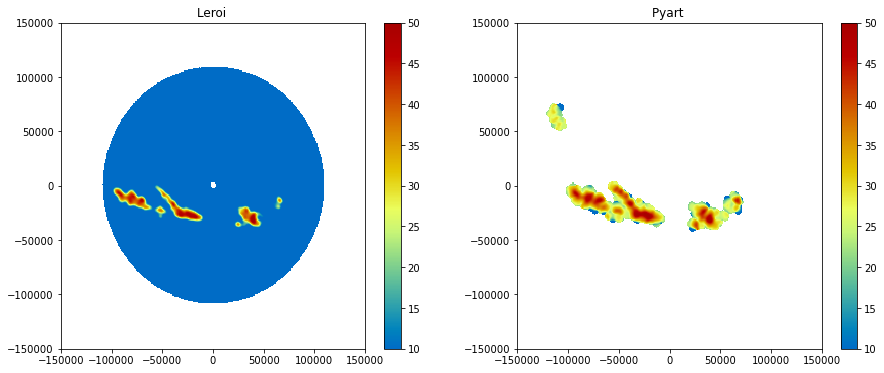

In [28]:
zidx = 5
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(121)
m = ax.pcolormesh(x,y,f_leroi[zidx,...], cmap ='pyart_HomeyerRainbow', vmin = 10, vmax = 50)
plt.colorbar(m)
ax.set_title('Leroi ')

ax = fig.add_subplot(122)
m = ax.pcolormesh(x,y,f_const[zidx,...], cmap ='pyart_HomeyerRainbow', vmin = 10, vmax = 50)
plt.colorbar(m)
ax.set_title('Pyart ')
plt.show()

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-79-577a8184124e>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m = ax.pcolormesh(x,z,f_leroy[:,yidx,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 50)
<ipython-input-79-577a8184124e>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the co

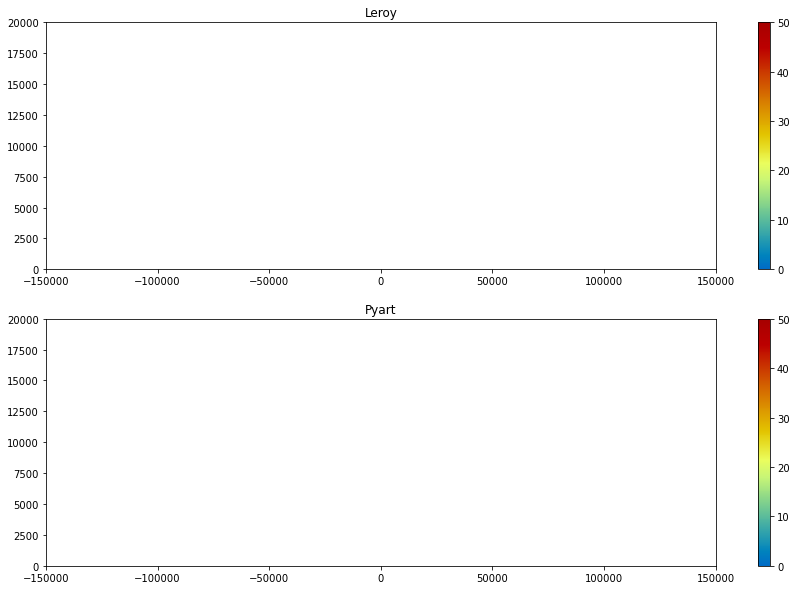

In [79]:
yidx = 70
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(211)
m = ax.pcolormesh(x,z,f_leroy[:,yidx,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 50)
plt.colorbar(m)
ax.set_title('Leroy')
ax = fig.add_subplot(212)
m = ax.pcolormesh(x,z,f_const[:,yidx,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 50)
plt.colorbar(m)
ax.set_title('Pyart')

plt.show()